# Sensitivity Analysis

The primary objectives for this analysis revolve around understanding the sensitivity of the NMF model to hyperparameters and identifying the elements that have the most significant impact on coherence scores.

In [92]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer

df = pd.read_csv('processced text.csv')
vec = TfidfVectorizer(max_df=0.95, min_df=2, max_features=1000)
tfidf = vec.fit_transform(df['preprocessed_text'])

In [93]:
dictionary = df['preprocessed_text'].apply(lambda x: list(x.split())).to_list()

[['point',
  'view',
  'prescriptive',
  'descriptive',
  'definite',
  'distinguish',
  'elizabeth',
  'mayhews',
  'first',
  'book',
  'flip',
  'decorate',
  'point',
  'view',
  'prescriptive',
  'descriptive',
  'definite',
  'distinguish',
  'elizabeth',
  'mayhews',
  'first',
  'book',
  'flip',
  'decorate',
  'ballantine',
  'book',
  'title',
  'function',
  'like',
  'picture',
  'flip',
  'book',
  'unfold',
  'frame',
  'frame',
  'page',
  'page',
  'photograph',
  'empty',
  'room',
  'fill',
  'object',
  'furniture',
  'extremely',
  'satisfying',
  'like',
  'watch',
  'stopaction',
  'film',
  'useful',
  'algebraic',
  'approach',
  'style',
  'book',
  'literature',
  'interior',
  'design'],
 ['ten',
  'highend',
  'design',
  'gallery',
  'offer',
  'percent',
  'modern',
  'midcentury',
  'modern',
  'furniture',
  'april',
  'ten',
  'highend',
  'design',
  'gallery',
  'include',
  'antik',
  'rth',
  'century',
  'cristina',
  'grajale',
  'moss',
  'offer

In [80]:
parameters = {
    'n_components': [2,3,4,5,6,7,8,9,10]
}


In [96]:
from sklearn.metrics import make_scorer
from helpers.topic_modelling import calc_coherence, get_topic_words

def coherence_score(model, X, y):
    topic_words = get_topic_words(model, vec, num_top_words=100)
    return calc_coherence(topic_words, dictionary, dictionary)

In [82]:
from sklearn.decomposition import NMF

nmf = NMF(n_components=3, random_state=696, max_iter=200, init='nndsvd')
nmf.fit(tfidf)

coherence_score(nmf, None, None)

0.6553921949586762

In [83]:
import numpy as np
from sklearn.decomposition import NMF

init_values = ['random', 'nndsvd', 'nndsvda', 'nndsvdar']
beta_loss_values = ['frobenius', 'kullback-leibler']
solver_values = ['cd', 'mu']

coherence_tensor = np.zeros((len(init_values), len(beta_loss_values), len(solver_values)))

for i, init in enumerate(init_values):
    for j, beta_loss in enumerate(beta_loss_values):
        for k, solver in enumerate(solver_values):
            try:
                nmf = NMF(n_components=3, random_state=696, max_iter=200, init=init, beta_loss=beta_loss)
                nmf.fit(tfidf)
                
                coherence_tensor[i, j, k] = coherence_score(nmf, None, None)
            except:
                print("Invalid combination, marking 0")
                coherence_tensor[i, j, k] = 0

Invalid combination, marking 0
Invalid combination, marking 0
Invalid combination, marking 0
Invalid combination, marking 0
Invalid combination, marking 0
Invalid combination, marking 0
Invalid combination, marking 0
Invalid combination, marking 0


In [84]:
coherence_tensor

array([[[0.65539219, 0.65539219],
        [0.        , 0.        ]],

       [[0.65539219, 0.65539219],
        [0.        , 0.        ]],

       [[0.65539219, 0.65539219],
        [0.        , 0.        ]],

       [[0.65539219, 0.65539219],
        [0.        , 0.        ]]])

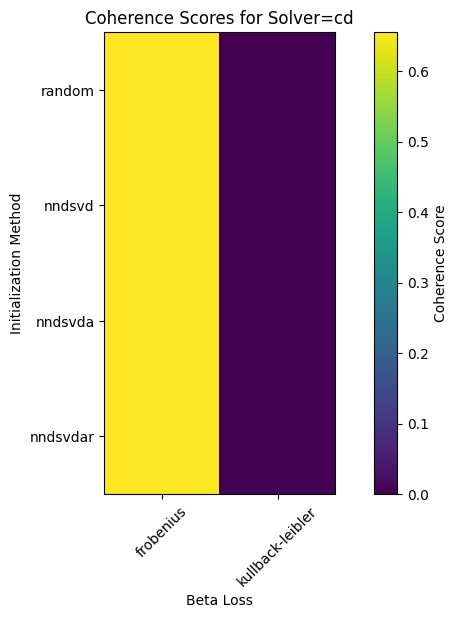

In [85]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.imshow(coherence_tensor[:, :, 0], cmap='viridis', interpolation='nearest')
plt.colorbar(label='Coherence Score')
plt.xticks(np.arange(len(beta_loss_values)), beta_loss_values, rotation=45)
plt.yticks(np.arange(len(init_values)), init_values)
plt.xlabel('Beta Loss')
plt.ylabel('Initialization Method')
plt.title('Coherence Scores for Solver=cd')
plt.show()

# Insights

We have observed the coherence scores reveals a surprising consistency in coherence scores across different combinations of hyperparameters—init, beta_loss, and solver. Despite systematically varying these parameters, the coherence scores remain constant.

This unexpected observation suggests that the NMF model may exhibit robustness or insensitivity to changes in certain hyperparameters within the explored range.

# Training on different n_components or number of topics



In [98]:
scores = []

for n_components in parameters['n_components']:
    nmf = NMF(init='nndsvd', random_state=696, max_iter=200, n_components=n_components)
    nmf.fit(tfidf)

    score = coherence_score(nmf, None, None)

    scores.append((n_components, score))


C:\Users\kevin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\decomposition\_nmf.py:1770: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


In [87]:
scores

[(2, 0.5481142629653311),
 (3, 0.6553921949586762),
 (4, 0.6594482217872112),
 (5, 0.5917895724868381),
 (6, 0.5896927273716327),
 (7, 0.5467159338315262),
 (8, 0.5294160127124499),
 (9, 0.5630327178722128),
 (10, 0.589621845292138)]

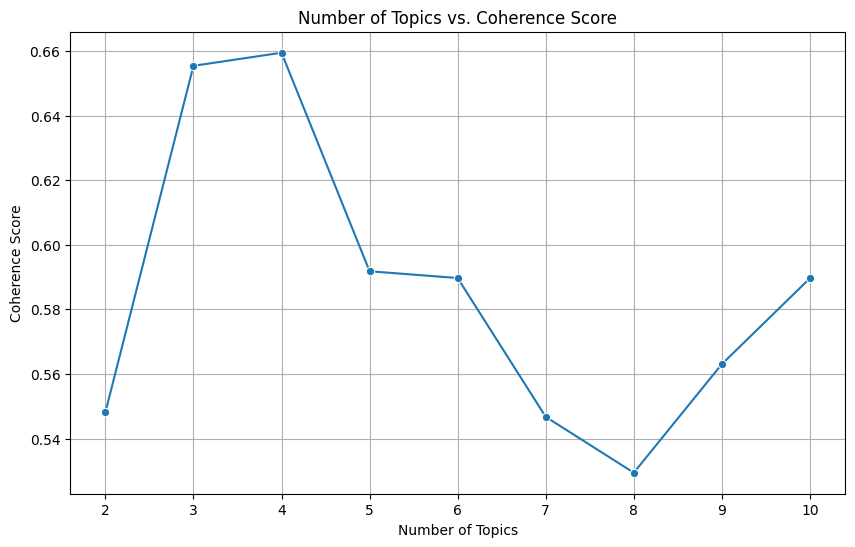

In [88]:
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.DataFrame(scores, columns=['Number of Topics', 'Coherence Score'])

plt.figure(figsize=(10, 6))
sns.lineplot(x='Number of Topics', y='Coherence Score', data=df, marker='o')
plt.title('Number of Topics vs. Coherence Score')
plt.xlabel('Number of Topics')
plt.ylabel('Coherence Score')
plt.grid(True)
plt.show()

# Insights

As the number of topics increases, we observe a non-linear trend in the coherence score.

Initially, as we increase the number of topics from 2 to 4, there is a significant improvement in the coherence score. This suggests that adding an additional topic allows for better separation and representation of distinct themes in the data, leading to higher coherence.

However, beyond 4 topics, further increasing the number of topics does not significantly improve coherence and may even result in a slight decrease in coherence. This could be due to topics becoming more granular or overlapping, making it harder to interpret and resulting in lower coherence.

| Number of Topics | Coherence Score |
|------------------|-----------------|
| 2                | 0.5481          |
| 3                | 0.6554          |
| 4                | 0.6594          |
| 5                | 0.5918          |
| 6                | 0.5897          |
| 7                | 0.5467          |
| 8                | 0.5294          |
| 9                | 0.5630          |
| 10               | 0.5896          |